# YoMaHa'07 data analysis: amplitude, phase, zonal wavelength

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.gridspec as gs
import h5py
import cftime
import matplotlib.dates as mdates
from astropy import timeseries
from scipy.optimize import lsq_linear
from statsmodels.formula.api import ols
import dask.config as dc
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import ScientificColourMaps6 as SCM6
from scipy import stats

import sys
sys.path.append("modules/")
import prepare_and_bin

In [ ]:
# set up batchjob
cluster = SLURMCluster(
    partition="cluster",
    walltime="08:00:00",
    cores=8,
    processes=8,
    memory="20 GB",
    env_extra=[
        "export LC_ALL=en_US.UTF-8",
        "export LANG=en_US.UTF-8"],
    interface="ib0")

In [ ]:
client = Client(cluster)
# add nodes
cluster.scale(64)

-------------
# Define function for harmonic fit to calculate amplitude and phase at EDJ frequency

In [ ]:
# harmonic fit
def xr_lsq(t, pyy, omega, dim, **kwargs):
    """Lsq harmonic fit."""
    
    def _lsq_ufunc(pyy, t, omega):
        valid = ~np.isnan(pyy)
        if ~np.any(valid):
            return np.array([np.nan, np.nan])
        A = np.vstack((np.cos(omega * t[valid]), np.sin(omega * t[valid]))).T
        result = lsq_linear(A, pyy[valid])
        return result.x

    def _lsq_along_axis(pyy, t, omega):
        return np.apply_along_axis(_lsq_ufunc, -1, pyy, t, omega)

    params = xr.apply_ufunc(
        _lsq_along_axis, pyy, t, omega, input_core_dims=[[dim], [dim], []],
        output_core_dims=[('coeff',)]
    )
    return params

--------------------
# Smoothed velocity field at 1000m depth

In [ ]:
# load data YoMaHa'07 data, select equatorial ocean, 1000m depth
lon, lat, time, depth, u = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-7,7))

# bin data
dt = 7  # in days, i.e. weekly
dlat = 0.1   # in degrees
dlon = dlat
binned_u_ds = prepare_and_bin.bin_argo(lon, lat, time, u, dlon, dlat, dt, (-7,7))

# select Atlantic
binned_u_ds_Atl = binned_u_ds.sel(lon=slice(-50, 10), lat=slice(-4,4))

In [ ]:
# some definitions for smoothing

longitude_axis = binned_u_ds_Atl.lon.values
latitude_axis = binned_u_ds_Atl.lat.values
time_axis = binned_u_ds_Atl.time.values

std_x = 3.75    # ~ half of decorrelation scales (Atlantic)
std_y = 0.15
def gaussian_ellipse(x0,y0):
    ge = np.exp( - ((longitude_axis[:, np.newaxis] - x0)**2/(2*std_x**2) + (latitude_axis - y0)**2/(2*std_y**2)))
    # put all values outside ellipse to NaN
    ge_2 = np.where((ge>np.exp(-3)), ge, np.nan)
    return ge_2.T

In [ ]:
# initialise array
smoothed_u = np.zeros((len(time_axis), len(latitude_axis), len(longitude_axis))) + np.nan

# smoothing
for i in range(0, len(longitude_axis), 5):
    for j in range(0, len(latitude_axis), 1):
        ge = gaussian_ellipse(longitude_axis[i], latitude_axis[j])
        time_series_temp = np.zeros(len(time_axis)) + np.nan
        for k in range(0, len(time_axis)):
            ge_norm = ge / np.nansum(ge[np.isfinite(binned_u_ds_Atl.binned_u[k,:,:].values)])    
                # normalised weights to retain physical amplitude of averaged u value
            time_series_temp[k] = np.nansum(binned_u_ds_Atl.binned_u[k,:,:].values * ge_norm)
        time_series_temp[(time_series_temp == 0)] = np.nan                    # nansum returns zero for all-NaN array... unwanted behavior
        smoothed_u[:, j, i] = time_series_temp

In [ ]:
# make xarray dataset from smoothed u, save as netcdf
smoothed_u_ds = xr.Dataset({"smoothed_u": (["time", "lat", "lon"], smoothed_u[:, :, ::5])},
                           coords={"time": (["time"], time_axis, {"unit": "days since 2000-01-01"}),
                                   "lat": (["lat"], latitude_axis),
                                   "lon": (["lon"], longitude_axis[::5])
                                  })
smoothed_u_ds.to_netcdf("derived_data/smoothed_u_ds_highestres.nc", mode="w")   # in cm/s!

---------
# Calculate EDJ amplitude and phase field from smoothed zonal velocity (for Figures 6a, 7a, 8a and further analysis)

In [ ]:
# define omega (EDJ angular frequency)
freq = 0.2174 / 365.25   # in 1/days
omega =  2 * np.pi * freq

In [ ]:
# calculate amplitude and phase
coeff = xr_lsq(smoothed_u_ds.time, smoothed_u_ds.smoothed_u, omega, 'time')
a, b = coeff.isel(coeff=0), coeff.isel(coeff=1)
amp_fit = np.sqrt(a ** 2 + b ** 2)
phase_fit = np.arctan2(-b, a)

amp_fit.to_dataset(name="amp_fit").to_netcdf("derived_data/amp_fit.nc", mode="w")
phase_fit.to_dataset(name="phase_fit").to_netcdf("derived_data/phase_fit.nc", mode="w")

-------
# Interpolate Etopo dataset for plotting of 1000m deep coastlines in Figures 6a, 7a, 8a, 12

In [ ]:
# load and prepare etopo data for plotting of coastlines at 1000m depth 
# (etopo data is also freely available)
etopo = xr.open_dataset("data/etopo/ETOPO1_Ice_g_gmt4.nc")
etopo_Atl = etopo.sel(x=slice(-51,16), y=slice(-5,5))
etopo_interp = etopo_Atl.interp(coords={"x": np.arange(-51, 16.1, 0.1), "y": np.arange(-5, 5.1, 0.1)}, method="linear")

--------------
# Figure 12: zonal acceleration of the mean flow by the EDJ

In [ ]:
# reconstruct velocity field varying only at the EDJ frequency from the amplitude and phase fit
fit = amp_fit * np.cos(omega * smoothed_u_ds.time + phase_fit)

#zonal acceleration:
mean_uu_dx = - ((fit / 100)**2).mean(dim="time").diff(dim="lon") / (0.5*111*1000)

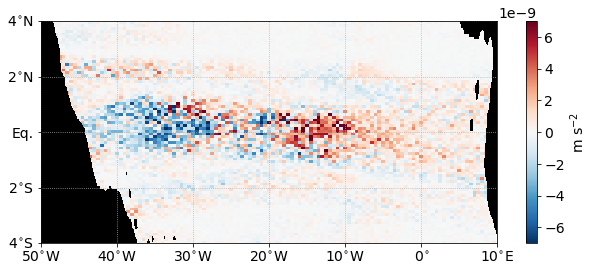

In [16]:
plt.rcParams["font.size"] = 14

plt.figure(figsize=(15,9))

gr = gs.GridSpec(2, 2, width_ratios=[3,1])

ax1 = plt.subplot(gr[0,0])
dat1 = mean_uu_dx.plot(vmin=-7e-9, vmax=7e-9, cmap="RdBu_r", add_colorbar=False, rasterized=True)
# dat1 = plt.contourf(lon_centre[::2], lat_centre[::2], ampldata[::2,::2].T, levels=np.arange(0,0.15,0.01), cmap="Oranges")
dat2 = plt.contourf(etopo_interp.x, etopo_interp.y, np.where((etopo_interp.z >= -1000), etopo_interp.z, np.nan), 
                   levels=(np.arange(-1000, 10000, 10000)), cmap="binary", vmin=-2000, vmax=-1000)
ax1.set_ylim([-4, 4])
ax1.set_xlim([-50,10])
ax1.set_xticks(np.arange(-50, 20, 10))
ax1.set_yticks(np.arange(-4,6,2))
ax1.set_xticklabels([f"{i}" + r"$^{\circ}$W" for i in np.arange(50,0,-10)] + [r"0$^{\circ}$"] + [r"10$^{\circ}$E"]) 
ax1.set_yticklabels((r"4$^{\circ}$S", r"2$^{\circ}$S", "Eq.", r"2$^{\circ}$N", r"4$^{\circ}$N"));
plt.grid(linestyle="dotted")
cb1 = plt.colorbar(dat1)
cb1.set_label(r"m s$^{-2}$")
plt.ylabel("")
plt.xlabel("")

plt.savefig("Figures/Figure12_mean_flow_acceleration.pdf", dpi=200, bbox_inches="tight")

-------------
# Figure 6 (amplitude)

In [ ]:
# Panel a: amplitude field
amp_fit = xr.open_dataset("derived_data/amp_fit.nc")  # as calculated above

### Calculation of values from original dataset (for table and red dots in Panels b of Figures 6, 7, 8)

In [ ]:
# amplitude:

lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-0.5,0.5))
# select mid-Atlantic
lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]

best_freq = 0.2174

amplitude = dict()

for i in np.arange(-37.5, 2.5, 5):
    u_temp = u_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    time_temp = time_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    
    ls_temp = timeseries.LombScargle(time_temp/365.25, u_temp)
    fit_temp = ls_temp.model(np.arange(0,20,0.01), best_freq)  # fit sinusoid
    amplitude[i] = 0.5*(np.max(fit_temp) - np.min(fit_temp))  # peak-to-peak amplitude

In [ ]:
# phase:

lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-1,1))
# select mid-Atlantic
lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]

phase = dict()

def phase_estimation(utimetuple):
    pyy, t = utimetuple
    freq = 0.2174 / 365.25   # in 1/days
    omega =  2 * np.pi * freq
    valid = ~np.isnan(pyy)
    if ~np.any(valid):
        return np.array([np.nan, np.nan])
    A = np.vstack((np.cos(omega * t[valid]), np.sin(omega * t[valid]))).T
    result = lsq_linear(A, pyy[valid])
    a, b = result.x[0], result.x[1]
    phase_fit = np.arctan2(-b, a)
    return phase_fit

for i in np.arange(-37.5, 2.5, 5):
    u_phase = u_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    time_phase = time_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    phase[i] = phase_estimation((u_phase, time_phase))

In [ ]:
# put data in arrays for saving
lon_axis = np.asarray(list(amplitude.keys()))
amplitude_array = np.zeros(8)
phase_array = np.zeros(8)
counter = 0
for key in amplitude.keys():
    amplitude_array[counter] = amplitude[key]
    phase_array[counter] = phase[key]
    counter += 1

In [ ]:
# zonal wavelength:
slope, _, _, _, _ = stats.linregress(lon_axis, phase_array)
wavelength = 2*np.pi / slope

In [ ]:
# save for plotting
yomaha_parameters_from_actual_data = xr.Dataset({"zonal_wavelength": wavelength,
                                                 "amplitude": (["lon"], amplitude_array),
                                                 "phase": (["lon"], phase_array)},
                                               coords={"lon": (["lon"], lon_axis)})
yomaha_parameters_from_actual_data.to_netcdf("derived_data/yomaha_parameters_from_actual_data.nc", mode="w")

### Bootstrapping for panel b

In [ ]:
lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha/yomaha07.dat", 1000, (-0.5,0.5))

# select mid-Atlantic
lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]

best_freq = 0.2174

In [ ]:
# define function that fits Sinusoid to data at peak frequency and returns amplitude

def amplitude_estimation(utimetuple):
    ls_temp = timeseries.LombScargle(utimetuple[1]/365.25, utimetuple[0])
    fit_temp = ls_temp.model(np.arange(0,20,0.01), best_freq)
    amplitude = 0.5*(np.max(fit_temp) - np.min(fit_temp))
    
    return amplitude

In [ ]:
%%time
# write loop over longitude bins, select data, apply bootstrapping and amplitude estimation
amplitudes = dict()

for i in np.arange(-37.5, 2.5, 5):
    u = u_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    time = time_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    
    def ampl_bootstrapping(N):     # N is dummy index for client.map
        # draw sample from original data (with replacement and same length)
        inds = np.random.choice(np.arange(0, len(u)), size=len(u), replace=True)  # indices necessary for keeping integrity of u/time pairs
        sample_u = u[inds]
        sample_time = time[inds]
        return (sample_u, sample_time)

    samplefutures = client.map(ampl_bootstrapping, np.arange(0, 10000))
    amplitudefutures = client.map(amplitude_estimation, samplefutures)
    amplitudes[i] = client.gather(amplitudefutures)

In [ ]:
# save data for plotting and table
amp_matrix = np.zeros((8, 10000))
counter = 0

# make matrix out of dictionary of amplitudes
for key in amplitudes.keys():
    amp_matrix[counter, :] = np.asarray(amplitudes[key])
    counter += 1
    
longitude_axis = np.asarray(list(amplitudes.keys()))

yomaha_amplitude_bootstrapping = xr.Dataset({"amplitudes": (["lon", "bootstrapping_instance"], amp_matrix)},
                                            coords={"lon": (["lon"], longitude_axis),
                                                    "bootstrapping_instance": (["bootstrapping_instance"], np.arange(0, 10000))})

yomaha_amplitude_bootstrapping.to_netcdf("derived_data/yomaha_amplitudes_bootstrapping.nc", mode="w")

### Mooring analysis for comparison in panel c (also for Figure 7c)

In [ ]:
# load mooring data at 23W
with h5py.File("data/Mooring_data/velocities_23W_2001_2019_interp.mat", "r") as file:
    U = np.array(file['U'])
    V = np.array(file['V'])
    P = np.array(file['P'])
    time = np.array(file['TIME'])
    
vel_23W_obs = xr.Dataset({'u':(['pres', 'time'], U.transpose()),
                         'v':(['pres', 'time'], V.transpose())},
                        coords={'pres': P[:,0],
                               'time': cftime.num2date(time[0,:]-365, 'days since 0001-01-01')}
                        )
vel_23W_obs = vel_23W_obs.chunk({'pres':20,'time':100})

u_selected = vel_23W_obs.u.sel(pres=slice(250, 2500))
# resample to monthly data
monthly_u = u_selected.resample(time="MS").mean()
# new time axis
new_time_in_days = cftime.date2num(monthly_u.time, "days since 2000-01-01")
# new dataset with time in days as dimension
monthly_u_newdim = xr.Dataset({"u": (["pressure", "time_days"], monthly_u)},
                             coords={"pressure": (["pressure"], monthly_u.pres),
                                     "time_days": (["time_days"], new_time_in_days)})

In [ ]:
# harmonic fit at EDJ frequency
freq = 0.2174 / 365.25   # in 1/day
omega =  2 * np.pi * freq
coeff = xr_lsq(monthly_u_newdim.time_days, monthly_u_newdim.u, omega, 'time_days')

a, b = coeff.isel(coeff=0), coeff.isel(coeff=1)
amp_fit = np.sqrt(a ** 2 + b ** 2)
phase_fit = np.arctan2(-b, a)

# save data
mooring_amplitude_phase_with_depth = xr.Dataset({"amplitude": (["pressure"], amp_fit),
                                                 "phase": (["pressure"], phase_fit)},
                                                coords={"pressure": (["pressure"], amp_fit.pressure)})
mooring_amplitude_phase_with_depth.to_netcdf("derived_data/mooring_amplitude_phase_with_depth_unsmoothed.nc", mode="w")

In [ ]:
# load mooring comparison data ad values for Figure 6c (calculation see above)
mooring_amplitude_phase = xr.open_dataset("derived_data/mooring_amplitude_phase_with_depth_unsmoothed.nc")
yomaha_data = xr.open_dataset("derived_data/yomaha_parameters_from_actual_data.nc")
yomaha_ampl_errorbars = xr.open_dataset("derived_data/yomaha_amplitudes_bootstrapping.nc").sel(lon=-23, method="nearest")

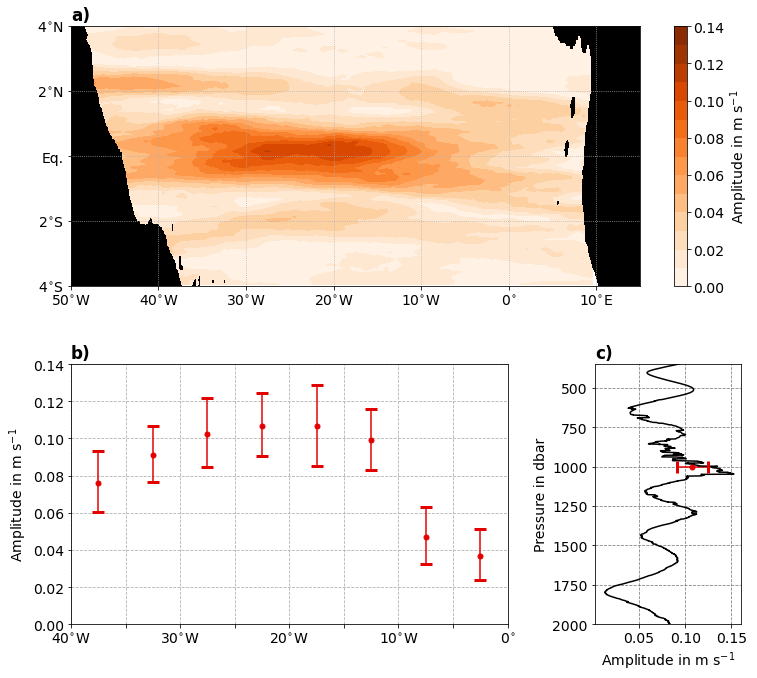

In [14]:
plt.figure(figsize=(12,11))

plt.rcParams["font.size"] = 14
f1 = lambda x: f"{x}" + r"$^{\circ}$W"
f2 = lambda x: ""

gr = gs.GridSpec(2, 2, hspace=0.3, wspace=0.3, width_ratios=[3,1])


ax1 = plt.subplot(gr[0,0:2])
dat1 = plt.contourf(amp_fit.lon, amp_fit.lat, amp_fit.amp_fit / 100, levels=np.arange(0,0.15,0.01), cmap="Oranges")
dat2 = plt.contourf(etopo_interp.x, etopo_interp.y, np.where((etopo_interp.z >= -1000), etopo_interp.z, np.nan), 
                   levels=(np.arange(-1000, 10000, 10000)), cmap="binary", vmin=-2000, vmax=-1000)
ax1.set_ylim([-4, 4])
ax1.set_xlim([-50,15])
plt.title("a)", loc="left", fontweight="bold")
ax1.set_xticks(np.arange(-50, 20, 10))
ax1.set_yticks(np.arange(-4,6,2))
ax1.set_xticklabels([f"{i}" + r"$^{\circ}$W" for i in np.arange(50,0,-10)] + [r"0$^{\circ}$"] + [r"10$^{\circ}$E"]) 
ax1.set_yticklabels((r"4$^{\circ}$S", r"2$^{\circ}$S", "Eq.", r"2$^{\circ}$N", r"4$^{\circ}$N"));
plt.grid(linestyle="dotted")

cb1 = plt.colorbar(dat1, orientation="vertical", fraction=0.1)
cb1.set_label(r"Amplitude in m s$^{-1}$")

ax2 = plt.subplot(gr[1,0])
plt.errorbar(yomaha_parameters_from_actual_data.lon, yomaha_parameters_from_actual_data.amplitude/100, 
             xerr=None, 
             yerr=[(yomaha_parameters_from_actual_data.amplitude - np.percentile(yomaha_amplitude_bootstrapping.amplitudes, 2.5, axis=1))/100, 
                   (np.percentile(yomaha_amplitude_bootstrapping.amplitudes, 97.5, axis=1) - yomaha_parameters_from_actual_data.amplitude)/100], 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3)
for i in range(0,8):
    plt.plot(yomaha_parameters_from_actual_data.lon[i], 
         yomaha_parameters_from_actual_data.amplitude[i]/100, marker=".", markersize=10, color="xkcd:red", linestyle="None")
ax2.set_ylim([0, 0.14])
plt.title("b)", loc="left", fontweight="bold")
ax2.set_xticks(np.arange(-50, 15, 5))
ax2.set_xticklabels(([f(i) for i in np.arange(50,0,-10) for f in (f1, f2)] + [r"0$^{\circ}$", "", ""]));
plt.ylabel(r"Amplitude in m s$^{-1}$")
ax2.set_xlim([-40,0])
plt.grid(linestyle="dashed")


ax3 = plt.subplot(gr[1,1])
plt.plot(mooring_amplitude_phase.amplitude, mooring_amplitude_phase.pressure, color="black")
plt.errorbar(yomaha_data.amplitude.sel(lon=-23, method="nearest") / 100, 1000,
             yerr=None, 
             xerr=np.asarray([(yomaha_data.amplitude.sel(lon=-23, method="nearest").values - np.percentile(yomaha_ampl_errorbars.amplitudes.values, 2.5)), 
                   (np.percentile(yomaha_ampl_errorbars.amplitudes.values, 97.5) - yomaha_data.amplitude.sel(lon=-23, method="nearest").values)])[:,None] / 100, 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3)
plt.plot(yomaha_data.amplitude.sel(lon=-23, method="nearest")/100, 1000, marker=".", color="xkcd:red", markersize=10)
ax3.invert_yaxis()
ax3.grid(color="grey", linestyle="dashed")
ax3.set_yticks(np.arange(250,2750,250))
ax3.set_ylim([2550, 300])
plt.xlabel(r"Amplitude in m s$^{-1}$")
ax3.set_ylim([2000, 350])
plt.ylabel("Pressure in dbar")
plt.title("c)", loc="left", fontweight="bold")

plt.savefig("Figures/Figure6_amplitude.pdf", bbox_inches="tight")

---------------
# Figure 7 (phase)

In [ ]:
# Panel a: phase field (calculation see top of the notebook)
phase_fit = xr.open_dataset("derived_data/phase_fit.nc")

In [ ]:
# Panel b: phases for different longitude bins, calculation see above in section on Figure 6
yomaha_parameters_from_actual_data = xr.open_dataset("derived_data/yomaha_parameters_from_actual_data.nc")

### Bootstrapping for panel b

In [ ]:
lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha07.dat", 1000, (-1,1))

# select mid-Atlantic
lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]

In [ ]:
def phase_estimation(utimetuple):
    pyy, t = utimetuple
    freq = 0.2174 / 365.25   # in 1/days
    omega =  2 * np.pi * freq
    valid = ~np.isnan(pyy)
    if ~np.any(valid):
        return np.array([np.nan, np.nan])
    A = np.vstack((np.cos(omega * t[valid]), np.sin(omega * t[valid]))).T
    result = lsq_linear(A, pyy[valid])
    a, b = result.x[0], result.x[1]
    phase_fit = np.arctan2(-b, a)
    return phase_fit

In [ ]:
%%time
# write loop over longitude bins, select data, apply bootstrapping and phase estimation
phases = dict()

for i in np.arange(-37.5, 2.5, 5):
    u_phase = u_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    time_phase = time_Atl[(lon_Atl>=i-2.5) & (lon_Atl<i+2.5)]
    
    def phase_bootstrapping(N):     # N is dummy index for client.map
        # draw sample from original data (with replacement and same length)
        inds = np.random.choice(np.arange(0, len(u_phase)), size=len(u_phase), replace=True)  # indices necessary for keeping integrity of u/time pairs
        sample_u = u_phase[inds]
        sample_time = time_phase[inds]
        return (sample_u, sample_time)

    samplefutures = client.map(phase_bootstrapping, np.arange(0, 10000))
    phasefutures = client.map(phase_estimation, samplefutures)
    phases[i] = client.gather(phasefutures)

In [ ]:
phases_array = dict()
for key in phases.keys():
    phases_array[key] = np.asarray(phases[key])

# save data for plotting and table
phase_matrix = np.zeros((8, 10000))
counter = 0
for key in phases_array.keys():
    phase_matrix[counter, :] = phases_array[key]
    counter += 1
longitude_axis = np.asarray(list(phases_array.keys()))

yomaha_phases_bootstrapping = xr.Dataset({"phases": (["lon", "bootstrapping_instance"], phase_matrix)},
                                            coords={"lon": (["lon"], longitude_axis),
                                                    "bootstrapping_instance": (["bootstrapping_instance"], np.arange(0, 10000))})

yomaha_phases_bootstrapping.to_netcdf("derived_data/yomaha_phases_bootstrapping.nc", mode="w")

### Mooring data for comparison in panel c

In [ ]:
# load mooring comparison data (calculated as above under Section Figur 6: amplitude)
mooring_amplitude_phase = xr.open_dataset("derived_data/mooring_amplitude_phase_with_depth_unsmoothed.nc")

# load Yomaha data
yomaha_data_phase = xr.open_dataset("derived_data/yomaha_parameters_from_actual_data.nc").sel(lon=-23, method="nearest")
yomaha_phase_errorbars = xr.open_dataset("derived_data/yomaha_phases_bootstrapping.nc").sel(lon=-23, method="nearest")

<ipython-input-18-e24d54d4a5d4>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  dat1 = plt.pcolor(phase_fit.lon, phase_fit.lat, phase_fit.phase_fit, cmap=SCM6.romaO, vmin=-np.pi, vmax=np.pi, rasterized=True)


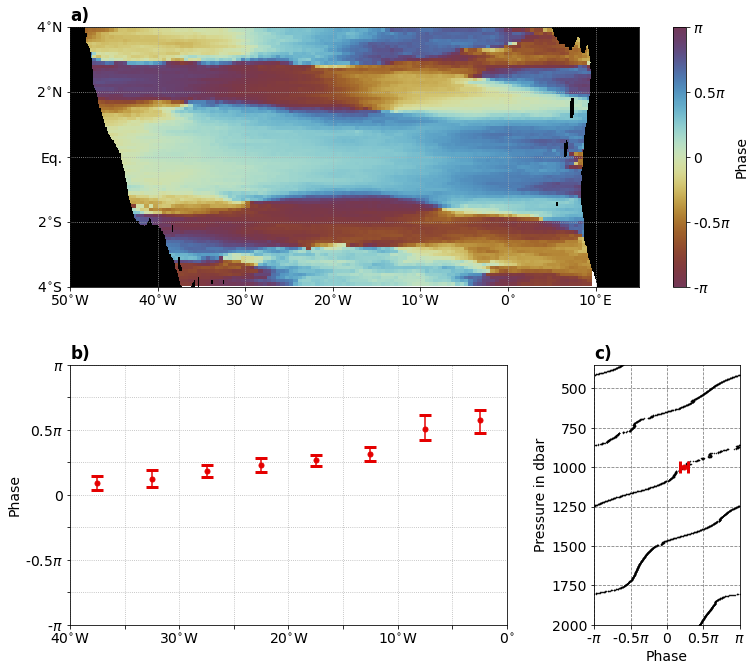

In [18]:
plt.figure(figsize=(12,11))

plt.rcParams["font.size"] = 14
f1 = lambda x: f"{x}" + r"$^{\circ}$W"
f2 = lambda x: ""

gr = gs.GridSpec(2, 2, hspace=0.3, wspace=0.3, width_ratios=[3,1])


ax1 = plt.subplot(gr[0,0:2])
dat1 = plt.pcolor(phase_fit.lon, phase_fit.lat, phase_fit.phase_fit, cmap=SCM6.romaO, vmin=-np.pi, vmax=np.pi, rasterized=True)
dat2 = plt.contourf(etopo_interp.x, etopo_interp.y, np.where((etopo_interp.z >= -1000), etopo_interp.z, np.nan), 
                   levels=(np.arange(-1000, 10000, 10000)), cmap="binary", vmin=-2000, vmax=-1000)
ax1.set_ylim([-4, 4])
ax1.set_xlim([-50,15])
plt.title("a)", loc="left", fontweight="bold")
ax1.set_xticks(np.arange(-50, 20, 10))
ax1.set_yticks(np.arange(-4,6,2))
ax1.set_xticklabels([f"{i}" + r"$^{\circ}$W" for i in np.arange(50,0,-10)] + [r"0$^{\circ}$"] + [r"10$^{\circ}$E"]) 
ax1.set_yticklabels((r"4$^{\circ}$S", r"2$^{\circ}$S", "Eq.", r"2$^{\circ}$N", r"4$^{\circ}$N"));
plt.grid(linestyle="dotted")

cb1 = plt.colorbar(dat1, orientation="vertical", fraction=0.1)
cb1.set_label("Phase")
cb1.set_ticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi])
cb1.set_ticklabels([r"-$\pi$", r"-0.5$\pi$", "0", r"0.5$\pi$", r"$\pi$"])

ax2 = plt.subplot(gr[1,0])
plt.errorbar(yomaha_phases_bootstrapping.lon, yomaha_parameters_from_actual_data.phase.values, 
             xerr=None, 
             yerr=[(yomaha_parameters_from_actual_data.phase.values - np.percentile(yomaha_phases_bootstrapping.phases, 2.5, axis=1)), 
                   (np.percentile(yomaha_phases_bootstrapping.phases, 97.5, axis=1) - yomaha_parameters_from_actual_data.phase.values)], 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3)
# plt.plot(yomaha_phases_bootstrapping.lon, np.median(yomaha_phases_bootstrapping.phases, axis=1), marker="*", markersize=10, color="black", linestyle="None")
# actual data (without resampling)
for i in range(0,8):
    plt.plot(yomaha_parameters_from_actual_data.lon[i], yomaha_parameters_from_actual_data.phase[i], marker=".", color="xkcd:red", markersize=10)
ax2.set_ylim([-np.pi, np.pi])
ax2.set_xlim([-40,0])
plt.title("b)", loc="left", fontweight="bold")
plt.ylabel("Phase")
ax2.set_xticks(np.arange(-40,5,5))
ax2.set_xticklabels(([f(i) for i in np.arange(40,0,-10) for f in (f1, f2)] + [r"0$^{\circ}$"]));
ax2.set_yticks(np.arange(-np.pi, 1.25*np.pi, 0.25*np.pi))
ax2.set_yticklabels((r"-$\pi$", "", r"-0.5$\pi$", "", "0", "", r"0.5$\pi$", "", r"$\pi$"));
plt.grid(linestyle="dotted")

ax3 = plt.subplot(gr[1,1])
plt.plot(mooring_amplitude_phase.phase, mooring_amplitude_phase.pressure, color="black", marker=".", linestyle="None", markersize=1)
plt.errorbar(yomaha_data_phase.phase.values, 1000,
             yerr=None, 
             xerr=np.asarray([(yomaha_data_phase.phase.values - np.percentile(yomaha_phase_errorbars.phases, 2.5)), 
                   (np.percentile(yomaha_phase_errorbars.phases, 97.5) - yomaha_data_phase.phase.values)])[:,None], 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3)
plt.plot(yomaha_data_phase.phase, 1000, marker=".", color="xkcd:red", markersize=10)
ax3.invert_yaxis()
ax3.grid(color="grey", linestyle="dashed")
ax3.set_yticks(np.arange(250,2750,250))
ax3.set_ylim([2550, 300])
ax3.set_xlim([-np.pi, np.pi])
ax3.set_xticks([-np.pi, -0.5*np.pi, 0, 0.5*np.pi, np.pi])
ax3.set_xticklabels([r"-$\pi$", r"-0.5$\pi$", "0", r"0.5$\pi$", r"$\pi$"])
ax3.set_ylim([2000, 350])
plt.ylabel("Pressure in dbar")
plt.xlabel("Phase")
plt.title("c)", loc="left", fontweight="bold")

plt.savefig("Figures/Figure_7_phase.pdf", dpi=300, bbox_inches="tight")

--------------
# Figure 8 (zonal wavelength)

In [ ]:
# Panel a: zonal change of phase field
phase_fit = xr.open_dataset("derived_data/phase_fit.nc")   # as calculated at the top

# unwrap phase
ph_unwr = np.zeros((80,120)) + np.nan
for i in range(0, 80):
    ph_unwr[i, np.isfinite(phase_fit.phase_fit.isel(lat=i))] = np.unwrap(
        phase_fit.phase_fit.isel(lat=i)[np.isfinite(phase_fit.phase_fit.isel(lat=i))])

p_unwrapped = xr.Dataset({"phase_unwrapped": (["lat", "lon"], ph_unwr)},
                        coords={"lat": (["lat"], phase_fit.lat),
                                "lon": (["lon"], phase_fit.lon)})

### Bootstrapping for panel b

In [ ]:
def wavelength_bootstrapping(u, time):   
    # draw sample from original data (with replacement and same length)
    inds = np.random.choice(np.arange(0, len(u)), size=len(u), replace=True)  # indices necessary for keeping integrity of u/time pairs
    sample_u = u[inds]
    sample_time = time[inds]
    return (sample_u, sample_time)

def est_phase(utimetuple):
    pyy, t = utimetuple
    freq = 0.2174 / 365.25   # in 1/days
    omega =  2 * np.pi * freq
    valid = ~np.isnan(pyy)
    if ~np.any(valid):
        return np.array([np.nan, np.nan])
    A = np.vstack((np.cos(omega * t[valid]), np.sin(omega * t[valid]))).T
    result = lsq_linear(A, pyy[valid])
    a, b = result.x[0], result.x[1]
    phase_fit = np.arctan2(-b, a)
    return phase_fit

### 1. Distribution on equator

In [ ]:
# define wrapper function that iterates over longitude bins, calculates linear regression and returns the slope and intercept

def wavelength_estimation(N):   # N is dummy argument used for mapping N times to dask workers
    phase = np.zeros((8))
    counter = 0
    
    for i in range(-40, 0, 5): # 40W to 0E
        u_temp = u_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
        time_temp = time_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
        utimetuple = wavelength_bootstrapping(u_temp, time_temp)
        phase[counter] = est_phase(utimetuple)
        counter = counter+1
    slope, _, _, _, _ = stats.linregress(np.arange(-37.5,2.5,5), phase)
    
    return slope

In [ ]:
%%time
slopefutures = client.map(wavelength_estimation, np.arange(0, 10000))
slopes = client.gather(slopefutures)

# calculate zonal wavelength from regression slopes: 
wavelengths = 2*np.pi / np.asarray(slopes)

# save data for plotting and table
yomaha_zonal_wavelength_bootstrapping = xr.Dataset({"zonal_wavelength": (["bootstrapping_instance"], wavelengths)},
                                                  coords={"bootstrapping_instance": (["bootstrapping_instance"], np.arange(0, 10000))})
yomaha_zonal_wavelength_bootstrapping.to_netcdf("derived_data/yomaha_zonal_wavelength_bootstrapping.nc", mode="w")

### 2. Latitude-dependent quantiles

In [ ]:
%%time

mean = dict()
median = dict()
perc025 = dict()
perc975 = dict()
perc5 = dict()
perc95 = dict()
perc25 = dict()
perc75 = dict()

for latrange in np.arange(-4, 4.25, 0.25):
    
    lon_all, lat_all, time_all, depth_all, u_all = prepare_and_bin.prepare_argo("data/yomaha07.dat", 1000, (latrange-0.5, latrange+0.5))
    # select mid-Atlantic
    lon_Atl = lon_all[(lon_all > -55) & (lon_all < 15)]
    lat_Atl = lat_all[(lon_all > -55) & (lon_all < 15)]
    time_Atl = time_all[(lon_all > -55) & (lon_all < 15)]
    depth_Atl = depth_all[(lon_all > -55) & (lon_all < 15)]
    u_Atl = u_all[(lon_all > -55) & (lon_all < 15)]
    
    # define wrapper function that iterates over longitude bins, calculates linear regression and returns the slope and intercept

    def wavelength_estimation(N):   # N is dummy argument used for mapping N times to dask workers
        phase = np.zeros((8))
        counter = 0

        for i in range(-40, 0, 5): # 40W to 0E
            u_temp = u_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
            time_temp = time_Atl[(lon_Atl>=i) & (lon_Atl<i+5)]
            utimetuple = wavelength_bootstrapping(u_temp, time_temp)
            phase[counter] = est_phase(utimetuple)
            counter = counter+1
        phase_unwrapped = np.unwrap(phase)
        slope, _, _, _, _ = stats.linregress(np.arange(-37.5,2.5,5), phase_unwrapped)

        return slope
    
    slopefutures = client.map(wavelength_estimation, np.arange(0, 10000))
    slopes = client.gather(slopefutures)
    wavelengths = 2*np.pi / np.absolute(np.asarray(slopes))
    
    mean[latrange] = np.mean(wavelengths)
    median[latrange] = np.percentile(wavelengths, 50)
    perc025[latrange] = np.percentile(wavelengths, 2.5)
    perc975[latrange] = np.percentile(wavelengths, 97.5)
    perc5[latrange] = np.percentile(wavelengths, 5)
    perc95[latrange] = np.percentile(wavelengths, 95)
    perc25[latrange] = np.percentile(wavelengths, 25)
    perc75[latrange] = np.percentile(wavelengths, 75)

In [ ]:
# save data for plotting and table

lat_axis = np.asarray(list(median.keys()))
mean_array = np.zeros(len(lat_axis))
median_array = np.zeros(len(lat_axis))
perc025_array = np.zeros(len(lat_axis))
perc975_array = np.zeros(len(lat_axis))
perc5_array = np.zeros(len(lat_axis))
perc95_array = np.zeros(len(lat_axis))
perc25_array = np.zeros(len(lat_axis))
perc75_array = np.zeros(len(lat_axis))
counter = 0
for key in median.keys():
    mean_array[counter] = mean[key]
    median_array[counter] = median[key]
    perc025_array[counter] = perc025[key]
    perc975_array[counter] = perc975[key]
    perc5_array[counter] = perc5[key]
    perc95_array[counter] = perc95[key]
    perc25_array[counter] = perc25[key]
    perc75_array[counter] = perc75[key]
    counter += 1
    
yomaha_zonal_wavelength_lats_bootstrapping = xr.Dataset({"mean": (["lat"], mean_array),
                                                         "median": (["lat"], median_array),
                                                         "perc025": (["lat"], perc025_array),
                                                         "perc975": (["lat"], perc975_array),
                                                         "perc5": (["lat"], perc5_array),
                                                         "perc25": (["lat"], perc25_array),
                                                         "perc75": (["lat"], perc75_array),
                                                         "perc95": (["lat"], perc95_array)},
                                                       coords={"lat":(["lat"], lat_axis)})

yomaha_zonal_wavelength_lats_bootstrapping.to_netcdf("derived_data/yomaha_zonal_wavelength_bootstrapping_latitude_dependent.nc", mode="w")

In [ ]:
# load data for panel b
yomaha_zonal_wavel_bootstrapping = xr.open_dataset("derived_data/yomaha_zonal_wavelength_bootstrapping.nc")
yomaha_zonal_wavel_lats = xr.open_dataset("derived_data/yomaha_zonal_wavelength_bootstrapping_latitude_dependent.nc")
yomaha_parameters_from_actual_data = xr.open_dataset("derived_data/yomaha_parameters_from_actual_data.nc")   # calculated in Section on Figure 6, see above

/home/sbastin/miniconda3/envs/py3_argo/lib/python3.8/site-packages/xarray/plot/plot.py:945: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
<ipython-input-24-443c068083eb>:29: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb1 = plt.colorbar(dat1, cax=axc, orientation="horizontal", fraction=0.7, extend="None")
<ipython-input-24-443c068083eb>:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));


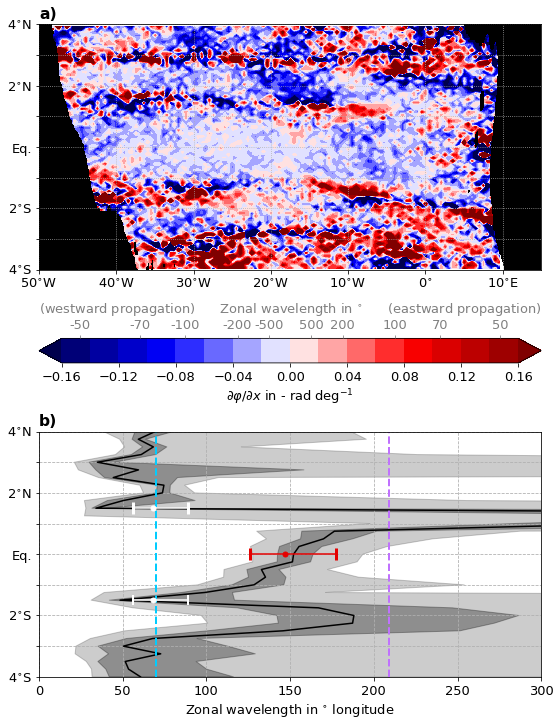

In [24]:
plt.figure(figsize=(9,12))

plt.rcParams["font.size"] = 13
f1 = lambda x: f"{x}" + r"$^{\circ}$W"
f2 = lambda x: ""

gr = gs.GridSpec(3, 1, hspace=0.4, height_ratios=[10,1,10])



ax1 = plt.subplot(gr[0])
dat1 = (- p_unwrapped.phase_unwrapped.diff(dim="lon")).plot.contourf(levels=np.arange(-0.16, 0.18, 0.02), vmin=-0.15, vmax=0.15, cmap="seismic", add_colorbar=False, rasterized=True)
dat2 = plt.contourf(etopo_interp.x, etopo_interp.y, np.where((etopo_interp.z >= -1000), etopo_interp.z, np.nan), 
                   levels=(np.arange(-1000, 10000, 10000)), cmap="binary", vmin=-2000, vmax=-1000)
ax1.set_ylim([-4, 4])
ax1.set_xlim([-50,15])
plt.title("a)", loc="left", fontweight="bold")
ax1.set_xticks(np.arange(-50, 20, 10))
ax1.set_yticks(np.arange(-4,5,1))
ax1.set_xticklabels([f"{i}" + r"$^{\circ}$W" for i in np.arange(50,0,-10)] + [r"0$^{\circ}$"] + [r"10$^{\circ}$E"]) 
ax1.set_yticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
plt.grid(linestyle="dotted")
plt.ylabel("")
plt.xlabel("")

axc = plt.subplot(gr[1])
cb1 = plt.colorbar(dat1, cax=axc, orientation="horizontal", fraction=0.7, extend="None")
cb1.set_label(r"$\partial \varphi / \partial x$ in - rad deg$^{-1}$")
axc2 = axc.twiny()
axc2.spines['top'].set_visible(False)
axc2.spines['right'].set_visible(False)
axc2.spines['bottom'].set_visible(False)
axc2.spines['left'].set_visible(False)
axc2.set_xlim([-0.15, 0.15])
axc2.set_xticks(2*np.pi/np.asarray([-50, -70, -100, -200, -500, 500, 200, 100, 70, 50]))
axc2.set_xticklabels([-50, -70, -100, -200, -500, 500, 200, 100, 70, 50], color="grey")
axc2.tick_params(axis="x", color="grey")
plt.xlabel(r"(westward propagation)" + "      " + r"Zonal wavelength in $^{\circ}$" + "      " + "(eastward propagation)", color="grey", labelpad=6)


ax2 = plt.subplot(gr[2])
plt.fill_betweenx(np.arange(-4, 4.25, 0.25), yomaha_zonal_wavel_lats.perc025, yomaha_zonal_wavel_lats.perc975, color="black", alpha=0.2)
plt.fill_betweenx(np.arange(-4, 4.25, 0.25), yomaha_zonal_wavel_lats.perc25, yomaha_zonal_wavel_lats.perc75, color="black", alpha=0.3)
plt.plot(yomaha_zonal_wavel_lats["median"], np.arange(-4, 4.25, 0.25), color="black")
plt.errorbar(yomaha_parameters_from_actual_data.zonal_wavelength, 0,
             yerr=None, 
             xerr=np.asarray([(yomaha_parameters_from_actual_data.zonal_wavelength - np.percentile(yomaha_zonal_wavel_bootstrapping.zonal_wavelength, 2.5)), 
                   (np.percentile(yomaha_zonal_wavel_bootstrapping.zonal_wavelength, 97.5) - yomaha_parameters_from_actual_data.zonal_wavelength)])[:,None], 
             fmt="none", ecolor="xkcd:red", capsize=6, capthick=3, zorder=300)
plt.plot(yomaha_parameters_from_actual_data.zonal_wavelength, 0, color="xkcd:red", marker=".", linestyle="None", markersize=10, zorder=400)
# theoretical wavelengths
plt.plot([209, 209], [-4, 4], linestyle="dashed", color="xkcd:easter purple", linewidth=2)
plt.plot([70, 70], [-4, 4], linestyle="dashed", color="xkcd:bright sky blue", linewidth=2)
# Youngs & Johnson
plt.errorbar(68, 1.5,
             yerr=None, 
             xerr=np.asarray([(68 - 56), 
                   (89 - 68)])[:,None], 
             fmt="none", ecolor="white", capsize=6, capthick=3, zorder=300)
plt.plot(68, 1.5, color="white", marker=".", linestyle="None", markersize=10)
plt.errorbar(68, -1.5,
             yerr=None, 
             xerr=np.asarray([(68 - 56), 
                   (89 - 68)])[:,None], 
             fmt="none", ecolor="white", capsize=5, capthick=2, zorder=300)
plt.plot(68, -1.5, color="white", marker=".", linestyle="None", markersize=10)
plt.grid(linestyle="dashed")
ax2.set_xlim([0, 300])
ax2.set_ylim([-4, 4])
ax2.set_yticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
plt.xlabel(r"Zonal wavelength in $^{\circ}$ longitude")
# ax2.set_xticks(np.arange(110,210,10))
# ax2.set_xticklabels(np.arange(-110, -210, -10))
plt.title("b)", loc="left", fontweight="bold")

plt.savefig("Figures/Figure8_ZonalWavelength.pdf", dpi=300, bbox_inches="tight")

----------------
# Figure 9 (Rossby and Kelvin wave)

In [ ]:
# Hermite polynomials
hermites = dict()
hermites[0] = lambda x: 1
hermites[1] = lambda x: 2*x
hermites[2] = lambda x: 4*x**2 - 2
hermites[3] = lambda x: 8*x**3 - 12*x
hermites[4] = lambda x: 16*x**4 - 48*x**2 + 12
hermites[5] = lambda x: 32*x**5 - 160*x**3 + 120*x
hermites[6] = lambda x: 64*x**6 - 480*x**4 + 720*x**2 - 120

In [ ]:
# Structure of Kelvin wave
def ustruct_K(y, c, beta):
    return np.exp(-beta*y**2 / (2*c))

In [ ]:
# Structure of Rossby wave
def ustruct_R(y, c, beta, n):
    fac1 = c - c/(2*n + 1)
    fac2 = c + c/(2*n + 1)
    h1 = 2**(-(n+1)/2) * hermites[n+1]((beta/c)**0.5 * y)
    h2 = n * 2**(-(n-1)/2) * hermites[n-1]((beta/c)**0.5 * y)
    
    return (fac1*h1 - fac2*h2) * np.exp(-beta*y**2 / (2*c)) 

In [ ]:
# define parameters and coordinates
beta = 2.3e-11  # (Gill, p. 434)
c = 0.16
y = np.arange(-4,4,0.1) * 111 * 1000   # in m
ylat = np.arange(-4,4,0.1)   # in degrees

Kelvin = ustruct_K(y, c, beta)
Rossby = ustruct_R(y, c, beta, 1)

# theoretical amplitude profiles
K_amp = np.absolute(Kelvin)
R_amp = np.absolute(Rossby/np.min(Rossby))    # normalised

In [ ]:
# load observed amplitude and phase data (fitted to YoMaHa'07 data, see top of the notebook)
amp_fit = xr.open_dataset("derived_data/amp_fit.nc")
phase_fit = xr.open_dataset("derived_data/phase_fit.nc")

# average between 28W and 17W, where EDJ are strongest:
amp_profile = amp_fit.amp_fit.sel(lon=slice(-28,-17)).mean(dim="lon")
phase_profile = phase_fit.phase_fit.sel(lon=slice(-28,-17)).mean(dim="lon")

# Values of Amplitude and phase profiles at minima at approximately 1.35S/N: (where Kelvin wave is dominant)
amp_K_23w = np.mean((amp_profile.sel(lat=-1.25, method="nearest"), amp_profile.sel(lat=1.45, method="nearest")))
phase_K_23w = np.mean((phase_profile.sel(lat=-1.25, method="nearest"), phase_profile.sel(lat=1.45, method="nearest")))

# fit theoretical Kelvin amplitude profile to this value
amplitude_Kelvin_23w = amp_K_23w / K_amp[(np.absolute(1.35 - (ylat*1.5)) == np.min(np.absolute(1.35 - (ylat*1.5))))]

# Kelvin wave peak amplitude
print(amplitude_Kelvin_23w.max())

In [ ]:
## subtract Kelvin signal from data, fit Rossby wave
K_y_interp_23w = amplitude_Kelvin_23w * np.interp(amp_fit.lat.values, ylat*1.5, Kelvin/np.max(Kelvin))

smoothed_u_ds = xr.open_dataset("derived_data/smoothed_u_ds_highestres.nc")
freq = 0.2174 / 365.25   # in 1/days
omega =  2 * np.pi * freq

## subtract Kelvin wave from entire u field (before harmonic fit), then calculate amplitude and phase again -> should now be close to Rossby wave
Kelvin_u_23w = K_y_interp_23w[None,:] * np.cos(omega*smoothed_u_ds.time.values[:,None] + phase_K_23w)

only_Rossby_signal_23w = smoothed_u_ds.sel(lon=slice(-28,-17)).mean(dim="lon").smoothed_u - Kelvin_u_23w

In [17]:
# harmonic fit of Rossby signal
coeff = xr_lsq(only_Rossby_signal_23w.time, only_Rossby_signal_23w, omega, 'time')
a, b = coeff.isel(coeff=0), coeff.isel(coeff=1)
amp_fit_Rossby = np.sqrt(a ** 2 + b ** 2)
phase_fit_Rossby = np.arctan2(-b, a)

data_to_fit = {"x": np.interp(amp_fit.lat.values, ylat*1.5, R_amp), 
               "z": amp_fit_Rossby.values}

model = ols("z ~ x -1", data_to_fit).fit()

# Print the summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      z   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              3406.
Date:                Fri, 04 Mar 2022   Prob (F-statistic):                    9.87e-67
Time:                        23:33:47   Log-Likelihood:                         -73.286
No. Observations:                  80   AIC:                                      148.6
Df Residuals:                      79   BIC:                                      151.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# theoretical Rossby phase profile
R_interp = 9.8*np.interp(amp_fit.lat.values, ylat*1.5, Rossby/np.min(Rossby))
Rossby_theoretical = R_interp[None,:] * np.cos(omega*smoothed_u_ds.time.values[:,None])
R_theo_ds = xr.Dataset({"R_theo": (["time", "lat"], Rossby_theoretical)},
                       coords={"time": (["time"], smoothed_u_ds.time),
                               "lat": (["lat"], smoothed_u_ds.lat)})
coeff = xr_lsq(R_theo_ds.time, R_theo_ds.R_theo, omega, 'time')
a, b = coeff.isel(coeff=0), coeff.isel(coeff=1)
amp_fit_Rossby_theo = np.sqrt(a ** 2 + b ** 2)
phase_fit_Rossby_theo = (np.arctan2(-b, a) + 2*np.pi)%(2*np.pi)

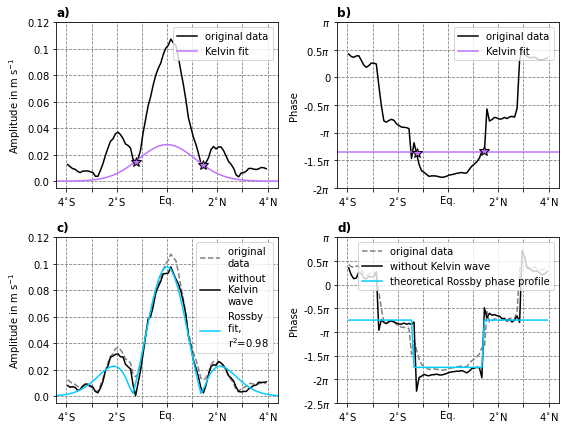

In [66]:
plt.figure(figsize=(9,7))

gr = gs.GridSpec(2, 2, hspace=0.3, wspace=0.27)

ax2 = plt.subplot(gr[0,0])
amp_profile.plot(color="black", label="original data")
plt.plot(ylat*1.5, K_amp*amplitude_Kelvin_23w, color="xkcd:easter purple", label="Kelvin fit")
plt.plot(-1.25, amp_profile.sel(lat=-1.25, method="nearest"), 
         marker="*", color="xkcd:easter purple", markeredgecolor="black", markersize=11)
plt.plot(1.45, amp_profile.sel(lat=1.45, method="nearest"), 
         marker="*", color="xkcd:easter purple", markeredgecolor="black", markersize=11)
plt.grid(color="grey", linestyle="dashed")
ax2.set_xlim([-4.4, 4.4])
ax2.set_xticks(np.arange(-4,5,1))
ax2.set_xticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
ax2.set_ylim([-0.5, 12])
ax2.set_yticks(np.arange(0,14,2))
ax2.set_yticklabels(np.arange(0,0.13,0.02))
plt.ylabel(r"Amplitude in m s$^{-1}$")
plt.title("a)", loc="left", fontweight="bold")
plt.xlabel("")
plt.legend(loc="upper right")

ax1 = plt.subplot(gr[0,1])
plt.plot(phase_profile.lat, np.unwrap(phase_profile), color="black", label="original data")
plt.plot([-4.5, 4.5], [phase_K_23w-2*np.pi, phase_K_23w-2*np.pi], color="xkcd:easter purple", label="Kelvin fit")
plt.plot(-1.25, phase_profile.sel(lat=-1.25, method="nearest")-2*np.pi, 
         marker="*", color="xkcd:easter purple", markeredgecolor="black", markersize=11)
plt.plot(1.45, phase_profile.sel(lat=1.45, method="nearest")-2*np.pi, 
         marker="*", color="xkcd:easter purple", markeredgecolor="black", markersize=11)
ax1.set_ylim([-2*np.pi, np.pi])
ax1.set_xlim([-4.4, 4.4])
ax1.set_yticks(np.arange(-2*np.pi, 1.5*np.pi, 0.5*np.pi))
ax1.set_yticklabels((r"-2$\pi$", r"-1.5$\pi$", r"-$\pi$", r"-0.5$\pi$", "0", r"0.5$\pi$", r"$\pi$"));
ax1.set_xticks(np.arange(-4,5,1))
ax1.set_xticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
plt.grid(color="grey", linestyle="dashed")
plt.title("b)", loc="left", fontweight="bold")
plt.legend(loc="upper right")
plt.ylabel("Phase")


ax3 = plt.subplot(gr[1,0])
amp_profile.plot(color="grey", linestyle="dashed")
amp_fit_Rossby.plot(color="black")
plt.plot(ylat*1.5, 9.8*R_amp, color="xkcd:bright sky blue")
plt.grid(color="grey", linestyle="dashed")
ax3.set_xlim([-4.4, 4.4])
ax3.set_xticks(np.arange(-4,5,1))
ax3.set_xticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
ax3.set_ylim([-0.5, 12])
ax3.set_yticks(np.arange(0,14,2))
ax3.set_yticklabels(np.arange(0,0.13,0.02))
plt.ylabel(r"Amplitude in m s$^{-1}$")
plt.title("c)", loc="left", fontweight="bold")
plt.legend(("original \ndata", "without \nKelvin \nwave", "Rossby \nfit, \n" + r"r$^2$=0.98"), loc="upper right")
plt.xlabel("")

phase_fit_Rossby_plot = phase_fit_Rossby

ax4 = plt.subplot(gr[1,1])
plt.plot(phase_profile.lat, np.unwrap(phase_profile), color="grey", linestyle="dashed")
plt.plot(phase_fit_Rossby.lat, phase_fit_Rossby, color="black")
(phase_fit_Rossby_theo - 1.75*np.pi).plot(color="xkcd:bright sky blue")    # just for visual comparison, arbitrary offset
ax4.set_ylim([-2.5*np.pi, np.pi])
ax4.set_yticks(np.arange(-2.5*np.pi, 1.5*np.pi, 0.5*np.pi))
ax4.set_yticklabels((r"-2.5$\pi$", r"-2$\pi$", r"-1.5$\pi$", r"-$\pi$", r"-0.5$\pi$", "0", r"0.5$\pi$", r"$\pi$"));
ax4.set_xticks(np.arange(-4,5,1))
ax4.set_xticklabels((r"4$^{\circ}$S", "", r"2$^{\circ}$S", "", "Eq.", "", r"2$^{\circ}$N", "", r"4$^{\circ}$N"));
ax4.set_xlim([-4.4, 4.4])
plt.grid(color="grey", linestyle="dashed")
plt.title("d)", loc="left", fontweight="bold")
plt.legend(("original data", "without Kelvin wave", r"theoretical Rossby phase profile"), loc="upper right")
plt.xlabel("")
plt.ylabel("Phase")

plt.savefig("Figures/Figure9_RossbyKelvin_28W-17W.pdf", bbox_inches="tight")